In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy.stats import laplace, norm
from scipy.optimize import curve_fit
#from scipy.stats import norm

%matplotlib inline

In [2]:
test_systems = pd.read_csv("../../csvs/deltatimes.csv", index_col =0)
#test_systems.head()


(249, 8)
Average Sigma 0.615753561685 Std in Sigma 0.262996916324
(249, 8)


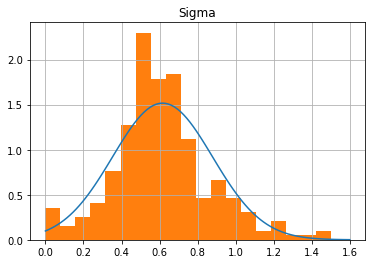

In [3]:

valid_info_frame= pd.read_csv("../../Figures/ConvolutedFigures/Convolved_Params_249_IOU_valid.csv")
print valid_info_frame.shape
valid_info_frame["Sigma"] = np.abs(valid_info_frame["Sigma"])
bins = np.linspace(0, 1.5, 20)

mu_fit, sig_fit =  norm.fit(valid_info_frame["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, 1.6, 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)
valid_info_frame.hist("Sigma", normed = 1, ax = ax, bins = bins)
print valid_info_frame.shape

In [4]:
from scipy.stats import norm
# p is the sigma distribution

valid_delta_times = test_systems[(test_systems["t"]>1e4) 
        & (test_systems["t"]<1e7) & (test_systems["t_shadow"]>1e4)
        & (test_systems["t_shadow"]<1e7)]
print valid_delta_times.shape
#print prob_sig[:10]
#print prob_sig.sum()
norm_prob_sig = prob_sig/(prob_sig.sum())
print norm_prob_sig[:10]
print x[:10]

(4825, 3)
[ 0.0015959   0.00183938  0.00211201  0.00241591  0.00275312  0.00312557
  0.00353504  0.00398308  0.00447099  0.00499975]
[ 0.          0.01616162  0.03232323  0.04848485  0.06464646  0.08080808
  0.0969697   0.11313131  0.12929293  0.14545455]


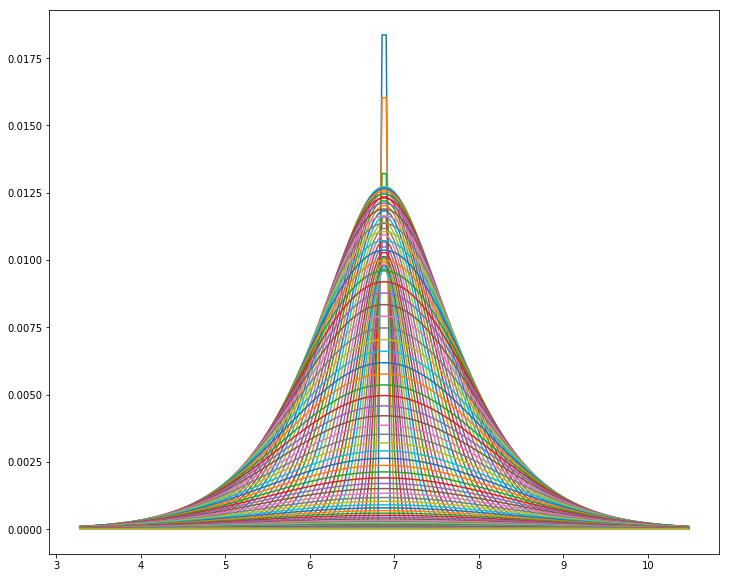

In [5]:
#Analytically over each of the mu;s, how to combine the sigmas?
#try with the first 100
trial = 10 #how many to test it with
max_sigma = 0.6 #the center, used to define bins
increments = 150 # how fine does the convoltion have to be?
#bins = np.linspace(0, 1.5, 20)

plt.figure(figsize=(12, 10))
#x is whawt stores the bins values (sigma values)
#prob_sig stpres the corresponding probability of that sigma
for i in range(5, trial,1):
    total_y= np.zeros(increments)
    for j in range(1,int(prob_sig.shape[0]), 1):
        fixed_sigma=x[j]
        t_sim = np.log10(valid_delta_times["t"].values[i])
        bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)

        #print t_sim
        #p = p*prob*norm_prob_sig[j]

        final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]
        
        total_y +=final_y
        
        plt.plot(bins, final_y )
    break
plt.show()


This graph is the summation of all the gaussians for ONE SYSTEM

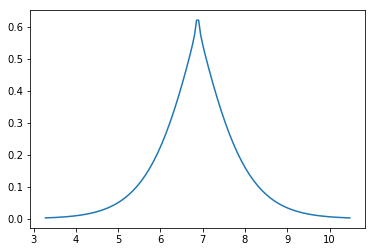

In [6]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
#print  width, bins[1] - bins[0]
#center, spread =laplace.fit(total_y)
#rv =laplace(loc = center, scale = spread)
#loc should be zero, since this should be symmetric about t = 0
# plt.plot(bins, rv.pdf(bins))
# NEed to do a least sqaures fit of a laplaec fit to this data

In [7]:
def laplace_fit(data, mean, spread):
    #data is your data
    #mean spread are the params you try to fit to the data
    return np.exp(-np.abs(data-mean)/spread)/2./spread

How to fit laplace function to this function, needs a least sqares fit, can't use laplace fit, as that requires the individual samples

[ 6.87973866  0.76514345]
[ 0.0030826   0.00436977]


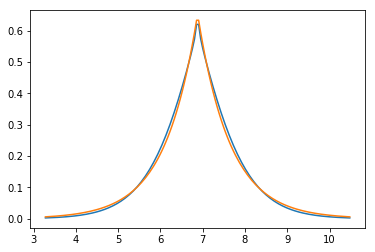

In [8]:
#function for optimizing the difference between total_Y(graph from)
#use the same x values,

popt, pcov = curve_fit(laplace_fit, bins, total_y)
print popt
perr = np.sqrt(np.diag(pcov))
print perr
plt.plot(bins, total_y)
plt.plot(bins, laplace_fit(bins, *popt))

Now try to do this for all 5000ish systems, and save the parameters and errors. Does this even make sense, as since we are only updating the t_sim parameter for each new distribution, wouldn't all the subsequent distributions look the same, with a shift?

In [9]:
#Analytically over each of the mu;s, how to combine the sigmas?
#try with the first 100
trial = 10 #how many to test it with
max_sigma = 0.6 #the center, used to define bins
increments = 150 # how fine does the convoltion have to be?
#bins = np.linspace(0, 1.5, 20)

#x is what stores the bins values (sigma values)
#prob_sig stpres the corresponding probability of that sigma
start = time.time()
for i in range(5, trial,1):
    total_y= np.zeros(increments)
    for j in range(1,int(prob_sig.shape[0]), 1):
        fixed_sigma=x[j]
        t_sim = np.log10(valid_delta_times["t"].values[i])
        bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
        final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
        total_y +=final_y
    break
end = time.time()
print end - start
#after above for loop runs for most values of sigma, we have the final 
#distribution, what are its laplace parameters?
        

0.0271921157837


Try plotting all the differences once the cut is made, to see if assumptions are still valid


In [10]:
reduced_systems = test_systems[(test_systems["t"] > 1e4) &
                              (test_systems["t"] < 1e7) &
                              (test_systems["t_shadow"] > 1e4)
                              & (test_systems["t_shadow"]<1e7)]
print reduced_systems.shape
reduced_systems["diff"] = np.log10(reduced_systems["t"]) -np.log10(reduced_systems["t_shadow"])
reduced_systems = reduced_systems.replace([np.inf, -np.inf], np.nan)
reduced_systems = reduced_systems.dropna()
print reduced_systems.shape
reduced_systems.head()

(4825, 3)
(4825, 4)


/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,runstring,t,t_shadow,diff
1,0000001.bin,1.348749e+05,213307.156880,-0.199074
21,0000021.bin,3.590242e+05,646731.388681,-0.255600
22,0000022.bin,2.025537e+06,311291.666001,0.813373
25,0000025.bin,3.708340e+05,671974.880182,-0.258173
28,0000028.bin,3.374641e+04,41949.192113,-0.094496


-0.00197534387546
0.407071371065


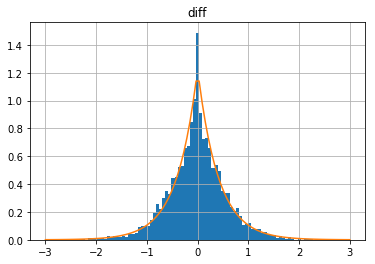

In [11]:
#print len(np.where(reduced_systems==-np.inf)[0])
#print np.where(reduced_systems ==-np.inf)
#print reduced_systems["diff"].min()
#print reduced_systems["diff"].max()
bins = np.linspace(-3,3,100)

reduced_systems.hist("diff", bins = bins, normed = 1)


fit1, fit2 =laplace.fit(reduced_systems["diff"].values)
print fit1
print fit2
#plot with it actually centered at zero
#, as any other value should be just due to noise
#if this was not the case, it would mean one end of the 
#distribution is  more prefered
rv =laplace(loc = 0, scale = fit2)
#loc should be zero, since this should be symmetric about t = 0
plt.plot(bins, rv.pdf(bins))


This seems to match the distribution we have been getting above,that we get that double exponential shape with the differences in the simulation times of the distributions that match the same period cuts

Just to make sure this is still valid, its still worthwhile doing that correlation test between mu and sigma, this should be very low, if not non exisitent

In [12]:
from scipy import stats
vals = stats.linregress(valid_info_frame["Mean"], valid_info_frame["Sigma"])
#the r value here is 0.305,
print vals
rvals = vals[2]
print rvals**2 # very low, don't need to worry about it

LinregressResult(slope=0.072101555076804338, intercept=0.16631976712670971, rvalue=0.30546212829388686, pvalue=8.9325057721538381e-07, stderr=0.014301081652498502)
0.0933071118218


Empty DataFrame
Columns: [Unnamed: 0, ID, Norm, Mean, Mean_Error, Sigma, Error, IOU]
Index: []
(249, 8)


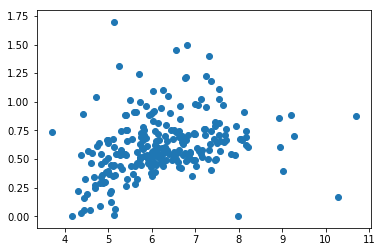

In [13]:
print valid_info_frame[valid_info_frame["Mean"] < 3]
plt.scatter(valid_info_frame["Mean"] , valid_info_frame["Sigma"])
print valid_info_frame.shape